# Generate ConvNeXt embeddings and visualize

<b> What is done here? <b>

This notebook loads a pre-trained ConvNeXt model from the Hugging Face Transformers library for feature extraction or other downstream tasks, without including a decoder or classification head. In other words, we load the ConvNeXt-Xlarge model pre-trained on ImageNet-22k at a resolution of 
224×224. This model excludes the decoder/classification head, meaning it outputs feature maps instead of class predictions.

Convnext is orthogonal to our ensembling idea becuase we can finetune the convnext model and ensemble that again and the idea of of convnext is that it doesnt overfit to a particular class as we might have with our de novo model which provides us with a baseline model to represent all classes fairly equally well. ConvNeXt is designed to generalize well across classes rather than overfitting to specific ones. Overfitting to certain classes can be problematic because it leads to poor generalization and bias.

<b> ConvNeXt architecture <b>

ConvNeXt is a convolutional neural network inspired by modern vision transformers (e.g., ViT) but maintains the simplicity of traditional convolution-based architectures like ResNet. It modifies standard CNNs to align closer to transformer architectures in their ability to capture long-range dependencies and achieve better performance.

The input image is divided into non-overlapping patches (similar to ViT).
Each patch is passed through a convolution layer to produce patch embeddings.

The encoder is divided into 4 stages, where each stage processes feature maps with different resolutions. Feature maps are downsampled as they progress through stages. The downsampling layers reduce the spatial dimensions (e.g. 2×2 convolutions with a stride of 2). Channel dimensions are increased to maintain feature representation. Key building blocks for processing feature maps. Uses depthwise separable convolutions (DWConv) for efficiency. The feature transformations involve: Layer Normalization (ConvNextLayerNorm), two-pointwise convolutions (PWConv1 and PWConv2), non-linear activation (GELU), dropPath regularization for robustness. 

Regardijg output: Each stage outputs a feature map that can be used for downstream tasks (e.g., classification, detection, or segmentation) or transfer learning or feature extraction.


Thus, the provided model consists of the following layers as follows:

* Embeddings:
Initial convolution layers split the image into 4×4 patches and map them to 256-dimensional embeddings.
ConvNeXtEncoder:

* Contains 4 stages:
Stage 1: Processes low-level features (spatial resolution is largest here).
Stage 2: Downsamples to 1/2 of the resolution and increases channels to 512.
Stage 3: Further downsampling and feature extraction (channels = 1024).
Stage 4: Final stage, channels = 2048.

* Decoder:
The code explicitly excludes the decoder (e.g., classification head). The model ends at the encoder, so it outputs high-dimensional feature representations.

In [1]:
!pip install torch torchvision transformers pillow numpy==1.26.4 anndata==0.10.3 scanpy==1.9.6 matplotlib gputil

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 10.2 MB 3.4 MB/s eta 0:00:01
     |████████████████████████████████| 18.2 MB 91.2 MB/s eta 0:00:01
     |████████████████████████████████| 119 kB 81.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 83.6 MB/s eta 0:00:01
     |████████████████████████████████| 53 kB 45.5 MB/s eta 0:00:01
     |████████████████████████████████| 10.8 MB 114.4 MB/s eta 0:00:01
     |████████████████████████████████| 232 kB 93.6 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 31.8 MB/s eta 0:00:01
     |████████████████████████████████| 468 kB 90.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 88.0 MB/s eta 0:00:01
     |████████████████████████████████| 471 kB 76.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 77.9 MB/s eta 0:00:01
     |████████████████████████████████| 42.4 MB 106.2 MB/s eta 0:00:01
     |█████████████████████

In [2]:
import numpy
print(numpy.__version__)

1.26.4


In [5]:
from transformers import AutoImageProcessor, ConvNextModel, ConvNextConfig
from PIL import Image
from torch.utils.data import DataLoader
import torch
#import anndata as ad
#import scanpy as sc
#import numpy as np
import matplotlib.pyplot as plt
import requests
import os

In [3]:
# os.chdir("pretrained_img_models/")

In [4]:
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


In [5]:
torch.cuda.empty_cache()

In [6]:
torch.cuda.is_available()

True

In [7]:
# config = ConvNextConfig()

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Should be without decoder https://huggingface.co/docs/transformers/v4.26.1/en/model_doc/convnext
# https://huggingface.co/facebook
# model = ConvNextModel.from_pretrained("facebook/convnext-xlarge-224-22k", config = config)
model = ConvNextModel.from_pretrained("facebook/convnext-xlarge-224-22k")
# Warning means decoder is not used

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:783: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [9]:
model.eval()
model.to(device)

ConvNextModel(
  (embeddings): ConvNextEmbeddings(
    (patch_embeddings): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
    (layernorm): ConvNextLayerNorm()
  )
  (encoder): ConvNextEncoder(
    (stages): ModuleList(
      (0): ConvNextStage(
        (downsampling_layer): Identity()
        (layers): Sequential(
          (0): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
            (act): GELUActivation()
            (pwconv2): Linear(in_features=1024, out_features=256, bias=True)
            (drop_path): Identity()
          )
          (1): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
            

In [10]:
# Cannot use ViTImageProcessor, had to install older version due to libssl error
# feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

In [11]:
#feature_extractor = AutoImageProcessor.from_pretrained("facebook/convnext-xlarge-224-22k")
feature_extractor = AutoImageProcessor.from_pretrained("facebook/convnext-xlarge-224-22k", do_rescale=False)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


# Biological classes

In [12]:
import torch
import torchvision

In [13]:
from sparcscore.ml.datasets import HDF5SingleCellDataset
from sparcscore.ml.utils import combine_datasets_balanced
import os
from sparcscore.ml.transforms import RandomRotation, GaussianNoise, ChannelReducer, ChannelSelector
from torchvision import transforms, utils

In [14]:
# !ls /mnt/dss_scratch/datasets/Autophagy_Screen_2

In [15]:
channel_classification = 4

# Expects 3D tensor: channels (=1), w, h
def multiply_channel(in_tensor):
    # out = torch.zeros((in_tensor.size()[0],3,1,1)) + in_tensor
    out = torch.zeros((3,1,1)) + in_tensor
    return out

In [16]:
t = transforms.Compose([ChannelSelector([channel_classification]), multiply_channel, feature_extractor])

In [16]:
# Initialize the HDF5SingleCellDataset with the new data
full_hdf5_data = HDF5SingleCellDataset(dir_list=['/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_EI24KO_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_EI24KO_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_EI24KO_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_EI24KO_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_A002/single_cells.h5', 
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_B004/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_D001/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_F003/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_H002/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_K001/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_Cr203_C6_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_Cr203_C6_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.3_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.3_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_unstim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_unstim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_1_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_2_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_1_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_2_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_1_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_2_0d.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_1_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_2_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_1_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_2_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_1_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_2_4h.h5'],
    dir_labels=[4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3],
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/',
    select_channel=4,  # This selects the 5th channel
    transform=t,
    return_id=False 
)

Total: 3426407
0: 407464
1: 209030
2: 400000
3: 9346
4: 7476
5: 2393091


In [28]:
# Base directory for the symbolic links
data_copy_dir = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/data_copy"

# List of file paths for each class
class_0_files = ['/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.3_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_2_14h.h5'
]


class_1_files = ['/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_unstim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_unstim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_1_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_2_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_1_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_2_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_1_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_2_0d.h5'
]


class_2_files = ['/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_Cr203_C6_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_Cr203_C6_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.3_stim_Cr203_filtered.h5'
]


class_3_files = ['/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_1_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_2_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_1_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_2_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_1_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_2_4h.h5'
]


class_4_files = ['/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_EI24KO_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_EI24KO_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_EI24KO_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_EI24KO_2_14h.h5'
]


class_5_files = ['/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_A002/single_cells.h5', 
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_B004/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_D001/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_F003/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_H002/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_K001/single_cells.h5'
]


classes = {
    "class_0": class_0_files,
    "class_1": class_1_files,
    "class_2": class_2_files,
    "class_3": class_3_files,
    "class_4": class_4_files,
    "class_5": class_5_files,

}


for class_name, file_list in classes.items():
    class_dir = os.path.join(data_copy_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)  
    
    for file_path in file_list:
        link_name = os.path.join(class_dir, os.path.basename(file_path))  # Define link path
        
        try:
            # Create the symbolic link pointing to the original file
            os.symlink(file_path, link_name)
            print(f"Linked {file_path} -> {link_name}")
        except OSError as e:
            print(f"Error creating symlink for {file_path}: {e}")

Linked /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_wt_filtered.h5 -> /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/data_copy/class_0/T_01_stim_wt_filtered.h5
Linked /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_wt_filtered.h5 -> /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/data_copy/class_0/T_2.2_stim_wt_filtered.h5
Linked /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.3_stim_wt_filtered.h5 -> /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/data_copy/class_0/T_2.3_stim_wt_filtered.h5
Linked /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_wt_filtered.h5 -> /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/data_copy/class_0/T_02_stim_wt_filtered.h5
Linked /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_

In [30]:
!ls -l /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/data_copy/class_0

total 5
lrwxrwxrwx 1 di93quv nogroup 150 Nov 11 13:38 231018_0316_EI24_fixed_tc_WT_1_14h.h5 -> /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_1_14h.h5
lrwxrwxrwx 1 di93quv nogroup 150 Nov 11 13:38 231018_0316_EI24_fixed_tc_WT_2_14h.h5 -> /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_2_14h.h5
lrwxrwxrwx 1 di93quv nogroup 150 Nov 11 13:38 231018_0317_EI24_fixed_tc_WT_1_14h.h5 -> /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_1_14h.h5
lrwxrwxrwx 1 di93quv nogroup 150 Nov 11 13:38 231018_0317_EI24_fixed_tc_WT_2_14h.h5 -> /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_2_14h.h5
lrwxrwxrwx 1 di93quv nogroup 150 Nov 11 

In [16]:
# One label per slide and simple in one
sources = [{'path': "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/data_copy/class_0", 'label': 0},
          {'path': "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/data_copy/class_1", 'label': 1},
          {'path': "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/data_copy/class_2", 'label': 2},
           {'path': "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/data_copy/class_3", 'label': 3},
          {'path': "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/data_copy/class_4", 'label': 4},
          {'path': "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/data_copy/class_5", 'label': 5},]

In [17]:
datasets = []
class_list = []

for source in sources:
    extraction_dir = os.path.join(source['path'])
    s = HDF5SingleCellDataset([extraction_dir],[source['label']],"/",transform=t,return_id=True)
    datasets.append(s)
    class_list.append(source['label'])

# dataset, _ = torch.utils.data.random_split(dataset, [size, residual])

Total: 407464
0: 407464
Total: 209030
1: 209030
Total: 400000
2: 400000
Total: 9346
3: 9346
Total: 7476
4: 7476
Total: 421444
5: 421444


In [18]:
size = 7000
# if size == 0:
#     size = len(dataset)
# residual = len(dataset) - size

dataset, _, _ = combine_datasets_balanced(datasets, class_list, size, 0, 0)

<sparcscore.ml.datasets.HDF5SingleCellDataset object at 0x7f980c479120> 0 1.0
<sparcscore.ml.datasets.HDF5SingleCellDataset object at 0x7f9836fc4700> 1 1.0
<sparcscore.ml.datasets.HDF5SingleCellDataset object at 0x7f994a9aef20> 2 1.0
<sparcscore.ml.datasets.HDF5SingleCellDataset object at 0x7f9815670730> 3 1.0
<sparcscore.ml.datasets.HDF5SingleCellDataset object at 0x7f9835ef09a0> 4 1.0
<sparcscore.ml.datasets.HDF5SingleCellDataset object at 0x7f9815670670> 5 1.0


In [19]:
dataloader = torch.utils.data.DataLoader(dataset,batch_size=100, num_workers=20, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [20]:
len(dataloader)

420

In [21]:
torch.cuda.empty_cache()

In [24]:
with torch.no_grad():
    data_iter = iter(dataloader)
    
    images, labels, class_ids = next(data_iter)
    images['pixel_values'] = images['pixel_values'][0].to(device)
    o = model(**images)
    output = o.pooler_output.cpu().detach()
    
    for i in (range(len(dataloader)-1)):
        #print("doing smth, not idle...")
        images, l, c_id = next(data_iter)
        images['pixel_values'] = images['pixel_values'][0].to(device)
        o = model(**images)
        output = torch.cat((output, o.pooler_output.cpu().detach()))
        labels = torch.cat((labels, l), 0)
        class_ids = torch.cat((class_ids, c_id), 0)

In [25]:
# Inspect input range
print(images["pixel_values"].min(), images["pixel_values"].max())

tensor(-2.1179, device='cuda:0') tensor(2.6400, device='cuda:0')


In [26]:
output.numpy().shape

(42000, 2048)

In [42]:
# Save results
np.save('./convnext_output_files/pool', output.numpy())
np.save('./convnext_output_files/labels', labels.numpy())
np.save('./convnext_output_files/class_ids', class_ids.numpy())

In [29]:
# Define file paths
pool_path = './convnext_output_files/pool.npy'
labels_path = './convnext_output_files/labels.npy'
class_ids_path = './convnext_output_files/class_ids.npy'

# Load the data
output_avg = np.load(pool_path)  
labels = np.load(labels_path)   
class_ids = np.load(class_ids_path)  

In [ ]:
output_avg = output.numpy()

In [ ]:
#output_avg = output_avg.reshape(output_avg.shape[0], 49)

In [28]:
output_avg.shape

(42000, 2048)

In [30]:
slides_classes = [0, 1, 2, 3, 4, 5]
classes = [slides_classes[x] for x in labels]

In [31]:
# ad_avg = ad.AnnData(output_avg, obs = labels.numpy())
ad_avg = ad.AnnData(output_avg, obs = classes)
ad_avg.obs.columns  = ["class_label"]

In [32]:
# Define the new class labels
class_labels = ["Class 0 (Stim.)", "Class 1 (Unstim.)", "Class 2 (ATG5 KO)", 
                "Class 3 (Stim. timecourse)", "Class 4 (EI24 KO timecourse)", "Class 5 (Screening)"]

# Create a mapping dictionary from the original numeric labels to the descriptive labels
label_mapping = {i: label for i, label in enumerate(class_labels)}

# Replace the labels in the 'class_label' column
ad_avg.obs['class_label'] = ad_avg.obs['class_label'].map(label_mapping)

In [33]:
ad_avg.obs

,class_label
0,Class 2 (ATG5 KO)
1,Class 5 (Screening)
2,Class 0 (Stim.)
3,Class 3 (Stim. timecourse)
4,Class 5 (Screening)
...,...
41995,Class 0 (Stim.)
41996,Class 5 (Screening)
41997,Class 5 (Screening)
41998,Class 1 (Unstim.)


In [34]:
ad_avg.obs['class_label'] = ad_avg.obs['class_label'].astype('category')

In [34]:
print(ad_avg)
print(ad_avg.shape)

AnnData object with n_obs × n_vars = 42000 × 2048
    obs: 'class_label'
(42000, 2048)


In [43]:
ad_avg.write("./convnext_output_files/ad_avg_data.h5ad")

In [ ]:
import anndata as ad
ad_avg = ad.read("./convnext_output_files/ad_avg_data.h5ad")

In [26]:
#ad_avg = ad_avg[ad_avg.obs["class_label"] != 2]

In [35]:
sc.pp.scale(ad_avg)

In [36]:
sc.pp.neighbors(ad_avg)
sc.tl.umap(ad_avg)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


### Plot everything

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


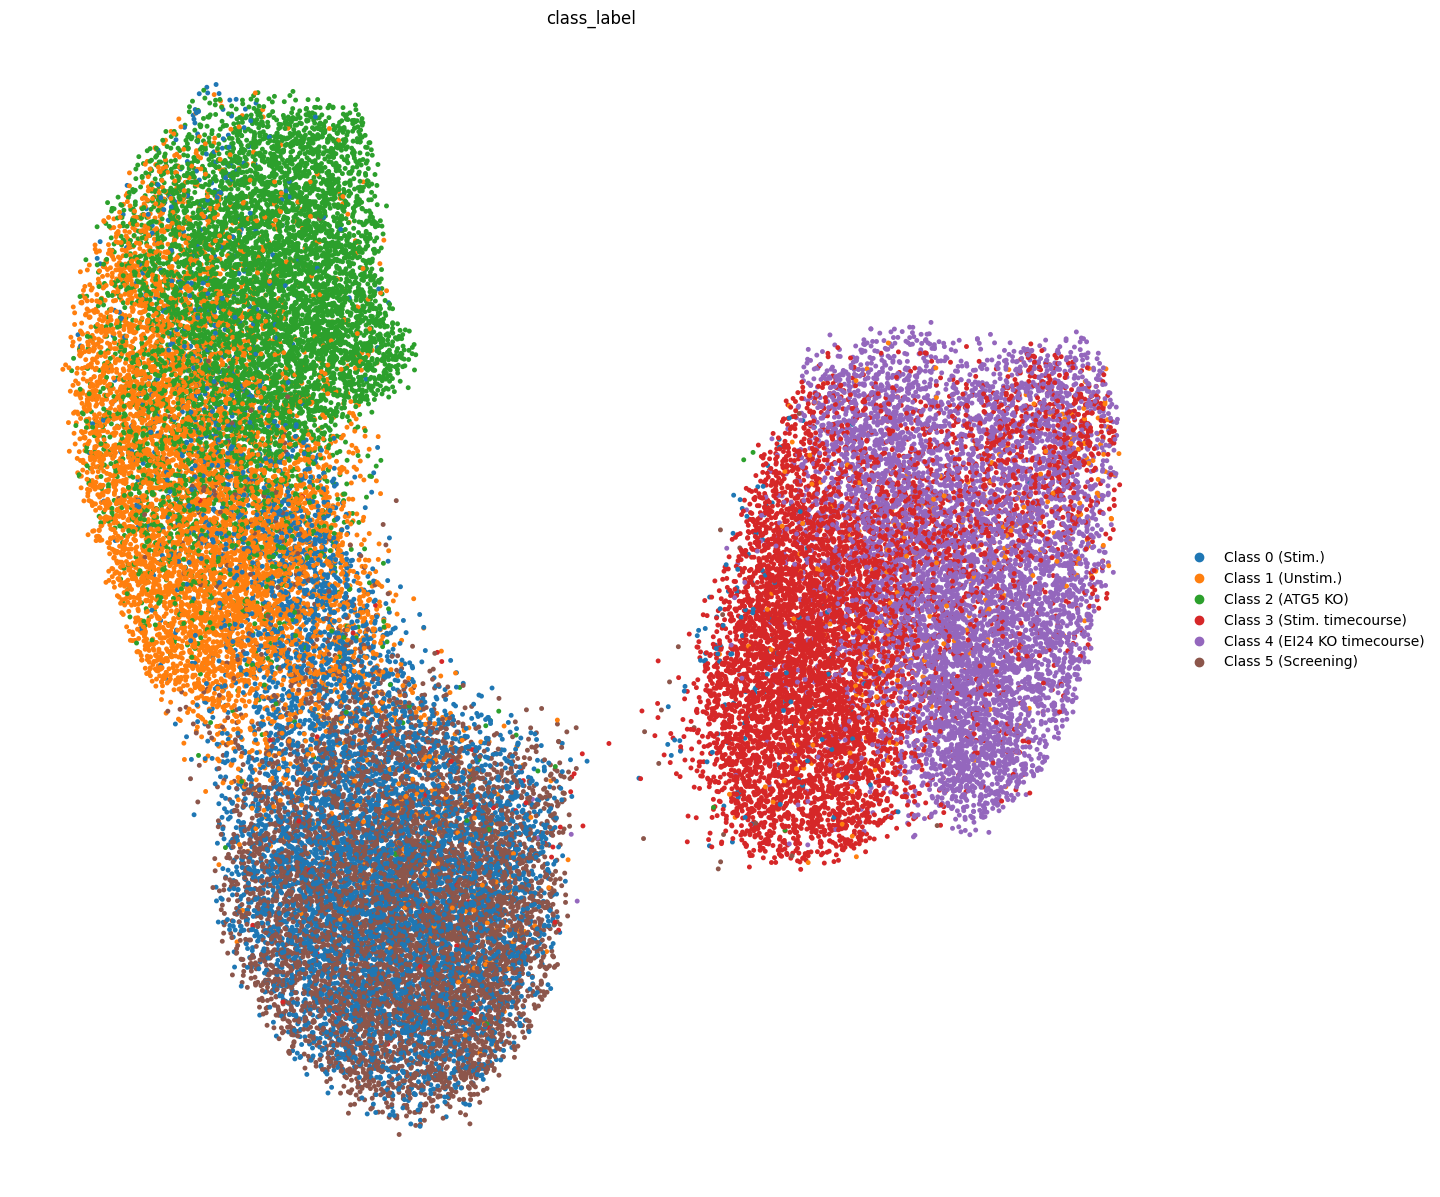

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
sc.pl.umap(ad_avg, color='class_label', ax=ax, s=50, frameon=False, show=False)
fig.savefig("./convnext_output_files/umap_plot_new.png", dpi=300)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'color_label'}, xlabel='UMAP1', ylabel='UMAP2'>

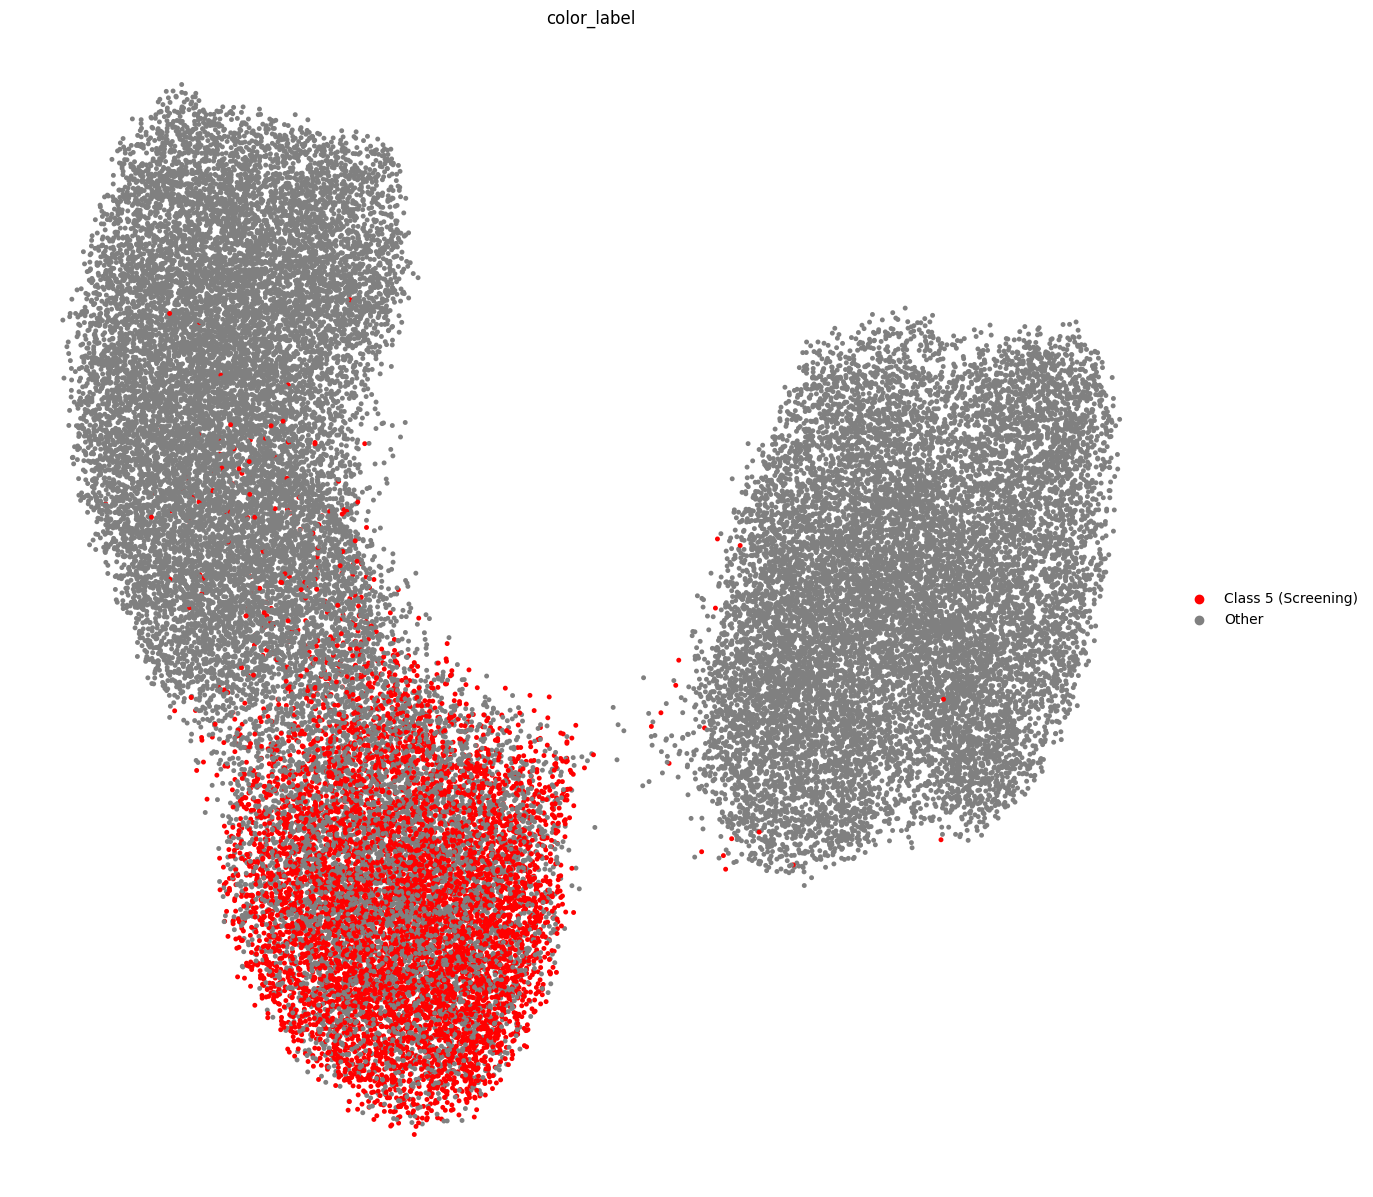

In [35]:
sc.pp.scale(ad_avg)
sc.pp.neighbors(ad_avg)
sc.tl.umap(ad_avg)

# Create a new column for the custom color labels
ad_avg.obs['color_label'] = ad_avg.obs['class_label'].apply(
    lambda x: 'Class 5 (Screening)' if x == 'Class 5 (Screening)' else 'Other'
)

# Define the colors for the categories
custom_colors = {'Class 5 (Screening)': 'red', 'Other': 'grey'}

# Plot the UMAP
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
sc.pl.umap(ad_avg, color='color_label', palette=custom_colors, ax=ax, s=50, frameon=False, show=False)

In [36]:
# Save the figure
fig.savefig("./convnext_output_files/umap_plot_class5_highlighted.png", dpi=300)

In [19]:
# Define the directory
save_path = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/convnext/"

# List all files in the directory
all_files = os.listdir(save_path)
print("Files in directory:", all_files)

Files in directory: ['case_2_1000_instances.pkl', 'case_1_1000_instances.pkl']


### Plot Class 0 (wt) and class 2 only (Cr203)

In [20]:
import anndata as ad
ad_avg = ad.read("./convnext_output_files/ad_avg_data.h5ad")

/usr/local/lib/python3.10/dist-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [21]:
#ad_avg = ad_avg[ad_avg.obs["class_label"] != 2]
# Select only the rows with class labels "Class 0 (Stim.)" and "Class 2 (ATG5 KO)"
ad_avg = ad_avg[(ad_avg.obs["class_label"] == "Class 0 (Stim.)") | 
                (ad_avg.obs["class_label"] == "Class 2 (ATG5 KO)")]

In [22]:
ad_avg.obs

,class_label
0,Class 2 (ATG5 KO)
2,Class 0 (Stim.)
6,Class 0 (Stim.)
7,Class 0 (Stim.)
9,Class 2 (ATG5 KO)
...,...
41982,Class 2 (ATG5 KO)
41989,Class 2 (ATG5 KO)
41992,Class 0 (Stim.)
41994,Class 2 (ATG5 KO)


In [40]:
sc.pp.scale(ad_avg)
sc.pp.neighbors(ad_avg)
sc.tl.umap(ad_avg)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


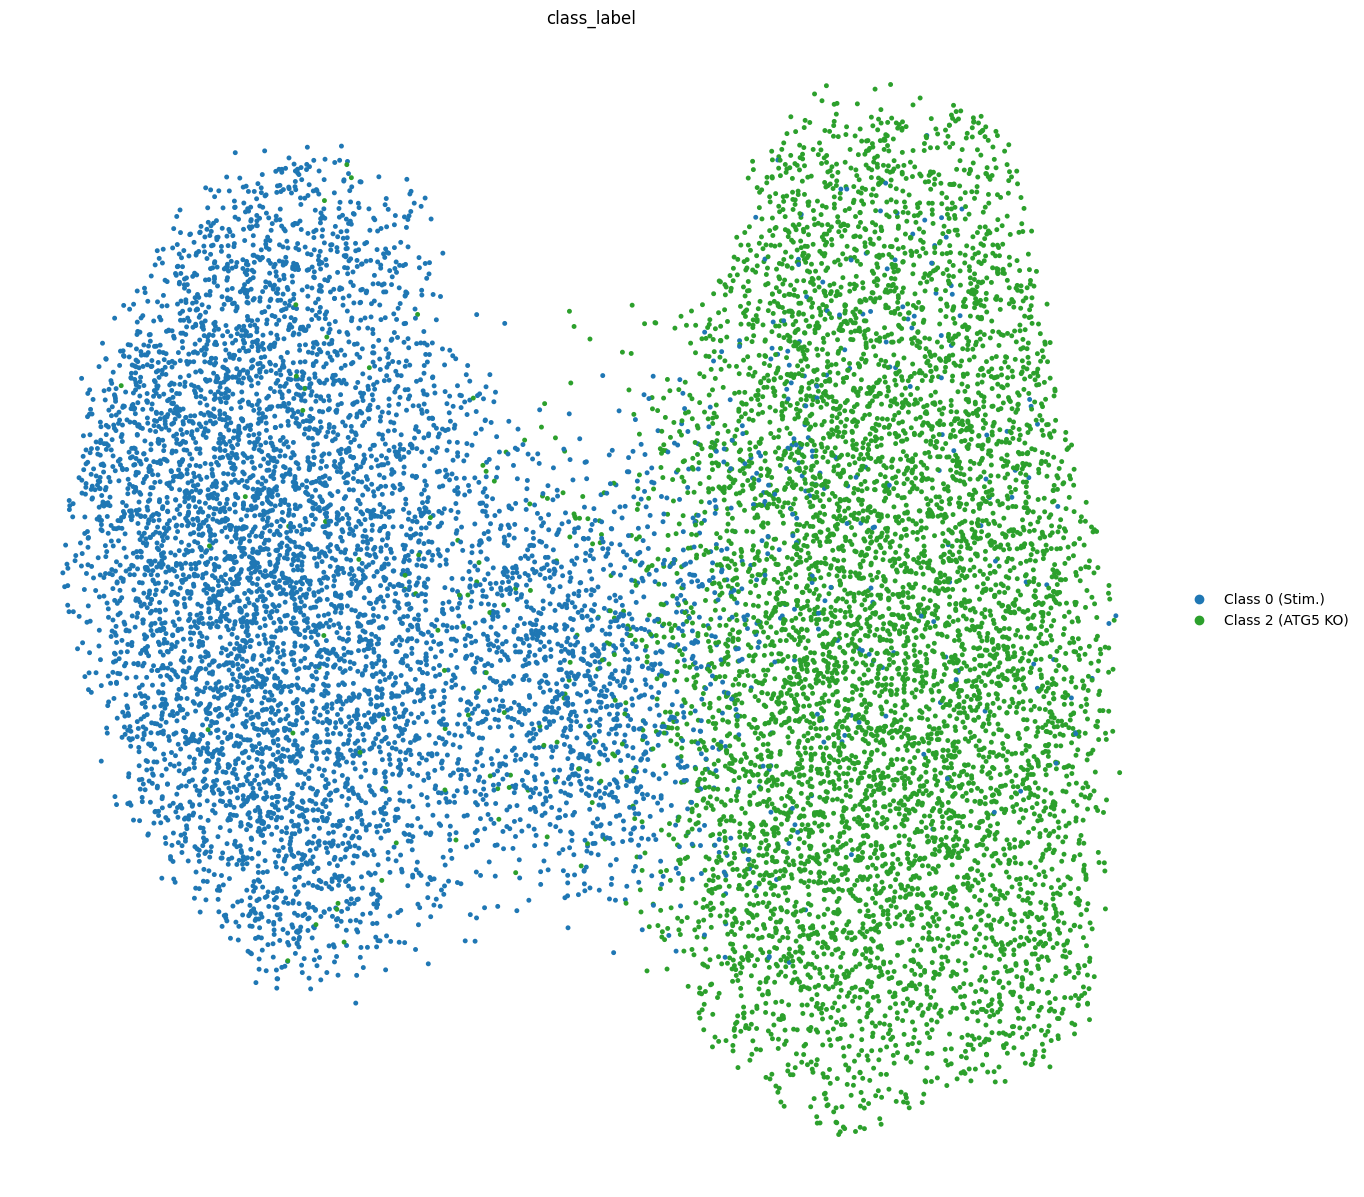

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
sc.pl.umap(ad_avg, color='class_label', ax=ax, s=50, frameon=False, show=False)
fig.savefig("./convnext_output_files/umap_wt_vs_cr203_plot_new.png", dpi=300)

In [31]:
# load amount of images per file given
# label is source file (last part of source path)
sources = [
{'file': 'x', 'num_imgs': 10000}
]

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained ConvNeXt model
model = ConvNextModel.from_pretrained("facebook/convnext-xlarge-224-22k")

# The structure includes:
# Embeddings:
# - Conv2d layer to create 256-dimensional embeddings from 4x4 patches
# - Layer Normalization (ConvNextLayerNorm)
#
# Encoder (ConvNextEncoder):
# - 4 stages, each with downsampling and convolutions:
#   Stage 1: Largest spatial resolution, channels = 256
#   Stage 2: Downsample to half resolution, channels = 512
#   Stage 3: Downsample further, channels = 1024
#   Stage 4: Final stage, channels = 2048

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:783: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device_idx = get_current_device_index()


In [9]:
from torchviz import make_dot

# Forward pass with a dummy tensor to generate the graph
dummy_input = torch.randn(1, 3, 224, 224).to(device)
output = model(dummy_input)

# Generate and save the visualization
make_dot(output, params=dict(model.named_parameters())).render("./convnext_architecture", format="png")

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [8]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 47 kB 2.6 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
